In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Load your dataset
data = pd.read_csv("processed_sample_dataset.csv")

In [5]:
# ===========================
# 1. Log Transformations
# ===========================
data['dolvol'] = data['dolvol'].apply(lambda x: x if x > 0 else 1e-6)
data['bm'] = data['bm'].apply(lambda x: x if x > 0 else 1e-6)
data['cashpr'] = data['cashpr'].apply(lambda x: x if x > 0 else 1e-6)

data['log_dolvol'] = np.log1p(data['dolvol'])
data['log_bm'] = np.log1p(data['bm'])
data['log_cashpr'] = np.log1p(data['cashpr'])

# ===========================
# 2. Interaction Terms
# ===========================
# Create selected interaction terms
data['interaction_macro_ep_tms'] = data['macro_ep'] * data['macro_tms']
data['interaction_macro_tms_dp'] = data['macro_tms'] * data['macro_dp']
data['interaction_macro_ep_dp'] = data['macro_ep'] * data['macro_dp']
data['interaction_beta_bm'] = data['beta'] * data['bm']

# Add ratios for interpretability
data['ratio_macro_ep_tms'] = data['macro_ep'] / (data['macro_tms'] + 1e-6)
data['ratio_macro_tms_dp'] = data['macro_tms'] / (data['macro_dp'] + 1e-6)

# Add differences for interpretability
data['difference_macro_tms_dp'] = data['macro_tms'] - data['macro_dp']
data['ratio_turn_dolvol'] = data['turn'] / (data['dolvol'] + 1e-6)
data['ratio_beta_dolvol'] = data['beta'] / (data['dolvol'] + 1e-6)
data['ratio_ps_bm'] = data['ps'] / (data['bm'] + 1e-6)
data['ratio_bm_age'] = data['bm'] / (data['age'] + 1e-6)

# ===========================
# 2. Polynomial Features (Simplified)
# ===========================
# Select features for polynomial transformation
poly_features = ['macro_ep', 'macro_tms', 'macro_dp']

# Generate polynomial terms up to degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_transformed = poly.fit_transform(data[poly_features])

# Get feature names and create DataFrame
poly_feature_names = poly.get_feature_names_out(poly_features)
poly_df = pd.DataFrame(poly_transformed, columns=poly_feature_names, index=data.index)

# Add only the interaction terms (excluding original features and squared terms)
interaction_terms = [name for name in poly_feature_names if "*" in name]
interaction_df = poly_df[interaction_terms]

# Concatenate interaction terms with the original DataFrame
data = pd.concat([data, interaction_df], axis=1)


# ===========================
# 5. Aggregate Features
# ===========================
data['mean_risk_premium_by_year'] = data.groupby('year')['risk_premium'].transform('mean')
data['std_turn_by_quarter'] = data.groupby(['year', 'quarter'])['turn'].transform('std')

# ===========================
# 6. Rolling or Cumulative Features
# ===========================
data['rolling_mean_risk_premium_3m'] = (
    data.groupby('permno')['risk_premium']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    .astype('float32')
)

data['rolling_std_turn_6m'] = (
    data.groupby('permno')['turn']
    .transform(lambda x: x.rolling(window=6, min_periods=1).std())
    .astype('float32')
)

# ===========================
# 7. Cyclical Encoding for Month
# ===========================
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# 8. additional 
data['interaction_rolling_mean_macro_tms'] = data['rolling_mean_risk_premium_3m'] * data['macro_tms']
data['interaction_rolling_std_turn_beta'] = data['rolling_std_turn_6m'] * data['beta']


# Interaction of cyclical encoding with key features
data['interaction_month_sin_turn'] = data['month_sin'] * data['turn']
data['interaction_month_cos_macro_tms'] = data['month_cos'] * data['macro_tms']

# ===========================
# Correlation Analysis
# ===========================
# Exclude non-numeric columns
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Compute correlation
correlation = numeric_data.corr()

# Sort correlation with respect to 'risk_premium'
print(correlation['risk_premium'].sort_values(ascending=False))

# Save the processed dataset
data.to_csv("feature_sample_dataset.csv", index=False)


risk_premium                 1.000000
mean_risk_premium_by_year    0.105756
interaction_macro_ep_dp      0.102607
macro_ep                     0.094187
baspread                     0.066509
                               ...   
macro_svar                  -0.099135
interaction_macro_ep_tms    -0.102803
ratio_macro_tms_dp          -0.110549
macro_tms                   -0.111838
interaction_macro_tms_dp    -0.112438
Name: risk_premium, Length: 86, dtype: float64


Correlation of Features with Risk Premium:
risk_premium                 1.000000
mean_risk_premium_by_year    0.105756
interaction_macro_ep_dp      0.102607
macro_ep                     0.094187
baspread                     0.066509
                               ...   
macro_svar                  -0.099135
interaction_macro_ep_tms    -0.102803
ratio_macro_tms_dp          -0.110549
macro_tms                   -0.111838
interaction_macro_tms_dp    -0.112438
Name: risk_premium, Length: 86, dtype: float64


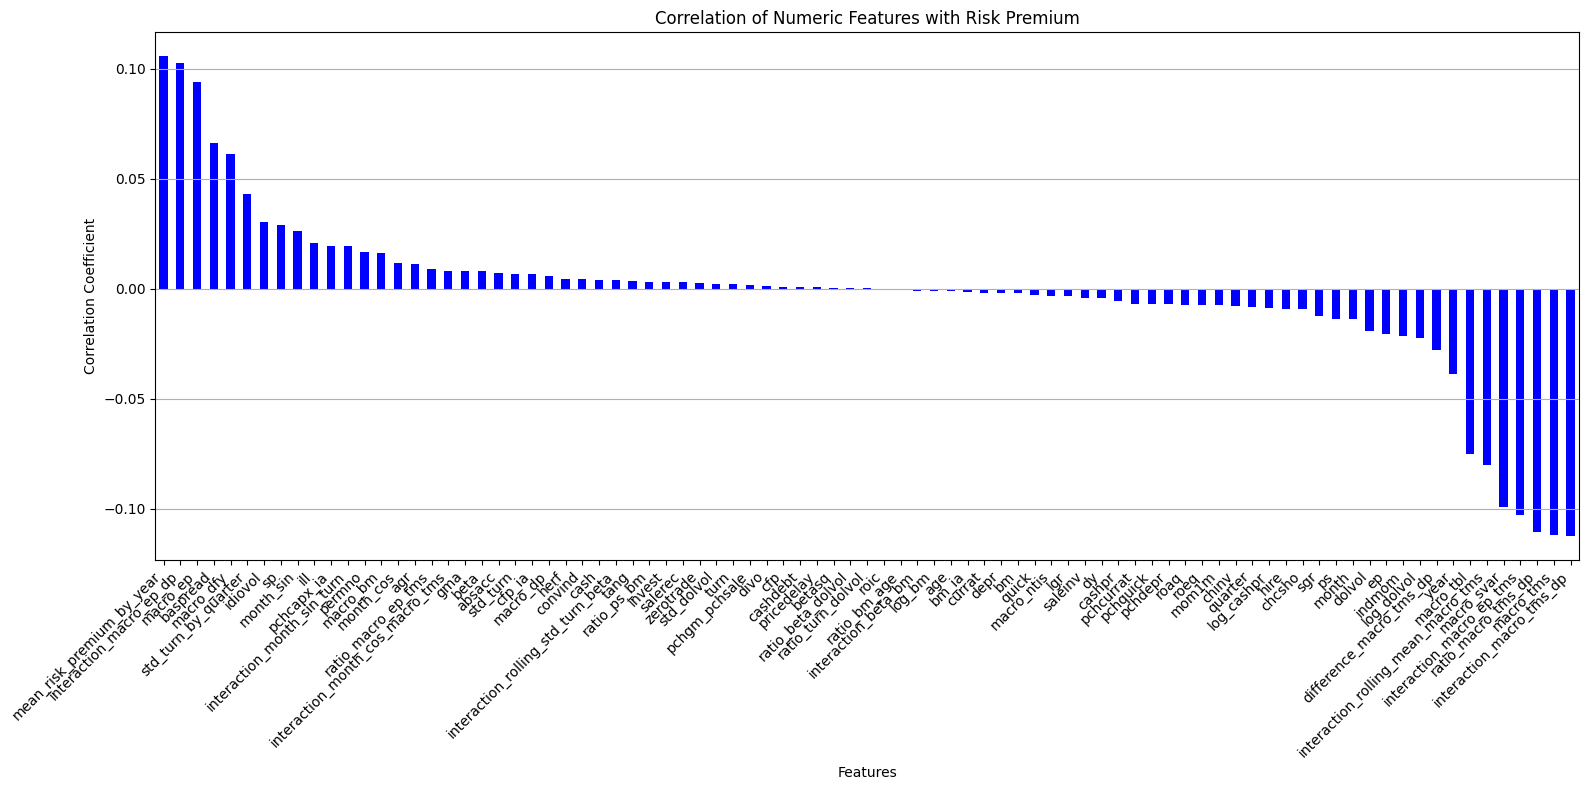

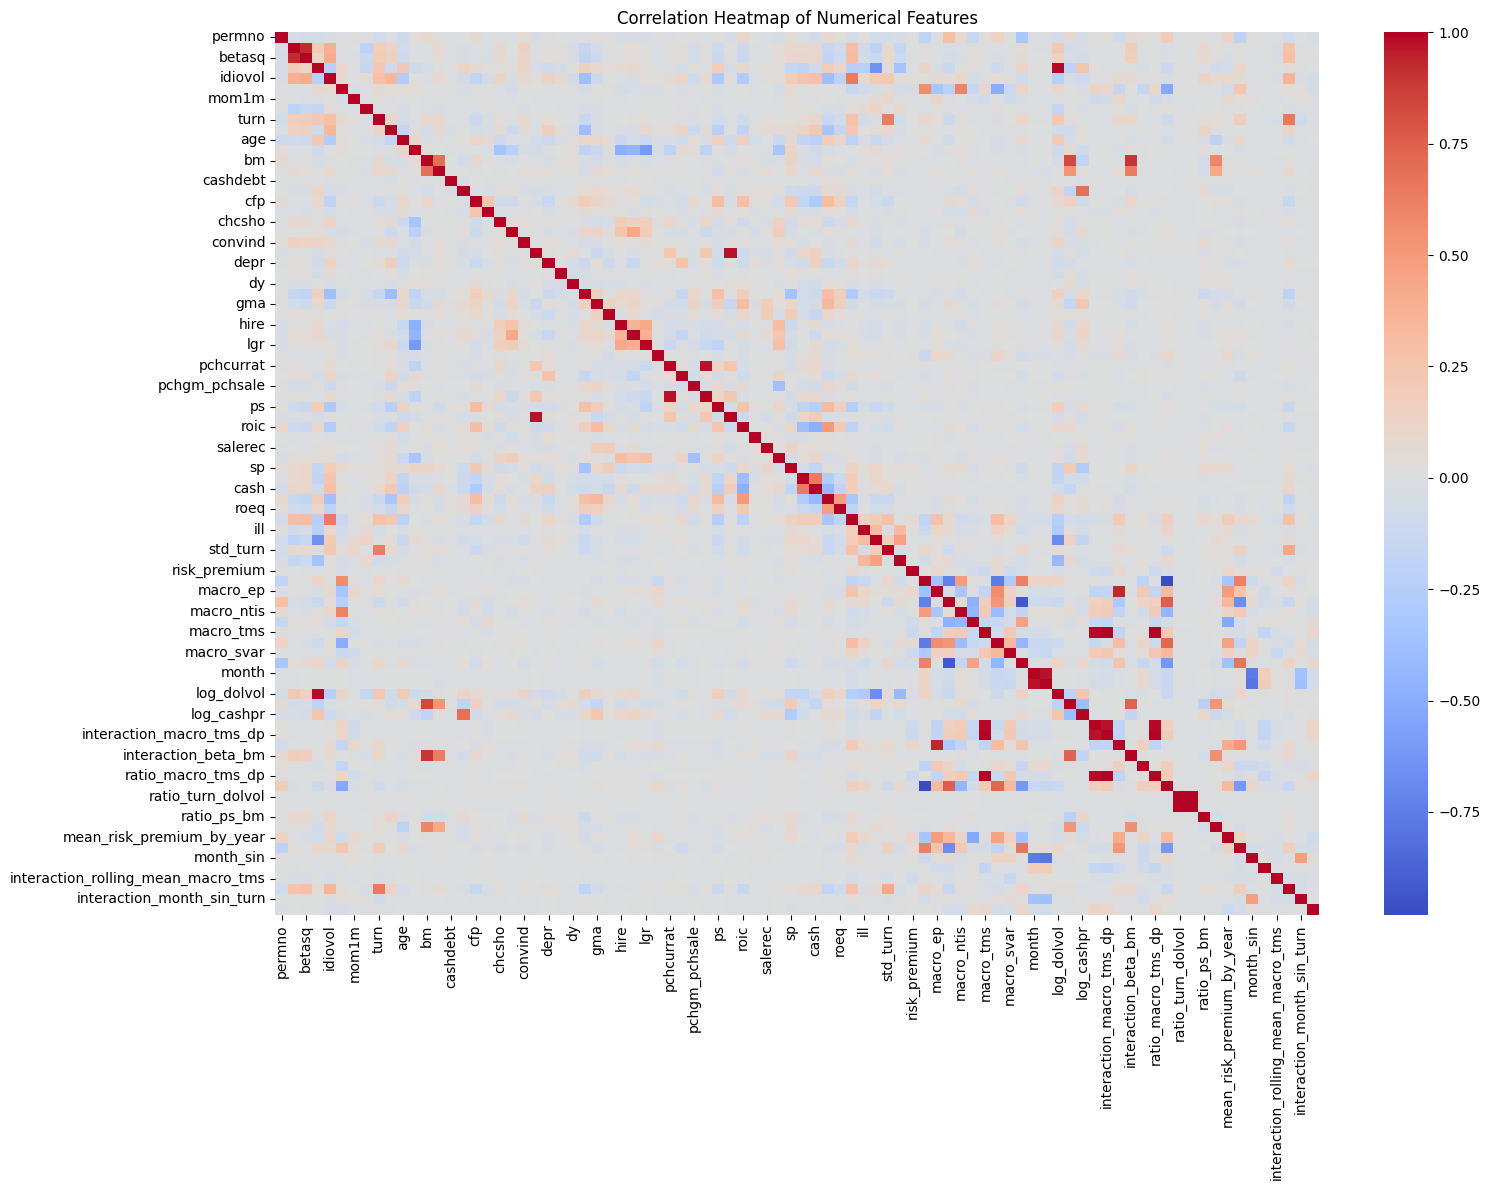

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures


# ===========================
# 1. Exclude Non-Numeric Columns
# ===========================
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# ===========================
# 2. Compute Correlation with Target (risk_premium)
# ===========================
correlation = numeric_data.corr()

# Sort correlation with respect to 'risk_premium'
target_corr = correlation['risk_premium'].sort_values(ascending=False)

# Print correlations
print("Correlation of Features with Risk Premium:")
print(target_corr)

# ===========================
# 3. Bar Chart of Feature Correlation
# ===========================
plt.figure(figsize=(16, 8))
target_corr.drop('risk_premium').plot(kind='bar', color='blue')  # Drop self-correlation
plt.title("Correlation of Numeric Features with Risk Premium")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()  # Ensure everything fits well
plt.show()

# ===========================
# 4. Heatmap of All Numeric Features
# ===========================
plt.figure(figsize=(16, 12))  # Adjust size as needed
sns.heatmap(correlation, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

# Load your dataset
data = pd.read_csv("feature_sample_dataset.csv")

# List of features to check
features_to_check = ['sic2', 'name', 'month', 'risk_premium']

# Check if each feature exists in the dataset
for feature in features_to_check:
    if feature in data.columns:
        print(f"Feature '{feature}' exists in the dataset.")
    else:
        print(f"Feature '{feature}' does NOT exist in the dataset.")


# 2. Identify and Drop Columns with Missing Values
# ===========================
# Use only numeric columns (remove target variable and non-numeric features)
X = data.select_dtypes(include=['int64', 'float64']).drop(columns=['risk_premium'])

# Check for missing values and identify columns to drop
missing_columns = X.columns[X.isna().sum() > 0].tolist()
print("Columns with missing values:", missing_columns)

# Drop columns with missing values
X = X.drop(columns=missing_columns)


Feature 'sic2' exists in the dataset.
Feature 'name' exists in the dataset.
Feature 'month' exists in the dataset.
Feature 'risk_premium' exists in the dataset.
Columns with missing values: ['rolling_std_turn_6m', 'interaction_rolling_std_turn_beta']


In [10]:
# Identify columns with NaN values
columns_with_nan = data.columns[data.isna().any()].tolist()

# Print the features being dropped
print(f"Features containing NaN values: {columns_with_nan}")

# Drop columns with NaN values
data_cleaned = data.drop(columns=columns_with_nan)

# Display the structure of the cleaned dataset
print("\nDataset after dropping columns with NaN values:")
print(data_cleaned.info())

# Save the cleaned dataset if needed
data_cleaned.to_csv("cleaned_sample_dataset.csv", index=False)
print("\nCleaned dataset saved as 'cleaned_dataset.csv'.")


Features containing NaN values: ['rolling_std_turn_6m', 'interaction_rolling_std_turn_beta']

Dataset after dropping columns with NaN values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890593 entries, 0 to 890592
Data columns (total 89 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   permno                              890593 non-null  int64  
 1   DATE                                890593 non-null  object 
 2   beta                                890593 non-null  float64
 3   betasq                              890593 non-null  float64
 4   dolvol                              890593 non-null  float64
 5   idiovol                             890593 non-null  float64
 6   indmom                              890593 non-null  float64
 7   mom1m                               890593 non-null  float64
 8   pricedelay                          890593 non-null  float64
 9   turn            

In [21]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv("cleaned_sample_dataset.csv")

# Separate features (exclude target variable)
X = data.drop(columns=['risk_premium'])

# Ensure only numeric data is used
X = X.select_dtypes(include=['float64', 'int64'])

# ===========================
# 2. Standardize the Data
# ===========================
# PCA requires the data to be standardized
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ===========================
# 3. Apply PCA
# ===========================
# Initialize PCA to retain 95% of the variance
pca = PCA(n_components=0.85)
X_pca = pca.fit_transform(X_scaled)

# Get the number of components
n_components = pca.n_components_
print(f"Number of components to retain 85% variance: {n_components}")

# Set a fixed number of components (e.g., 25) based on the elbow point
pca_fixed = PCA(n_components=25)
X_pca_fixed = pca_fixed.fit_transform(X_scaled)
print("Reduced to 25 components based on elbow point.")



Number of components to retain 85% variance: 42
Reduced to 25 components based on elbow point.


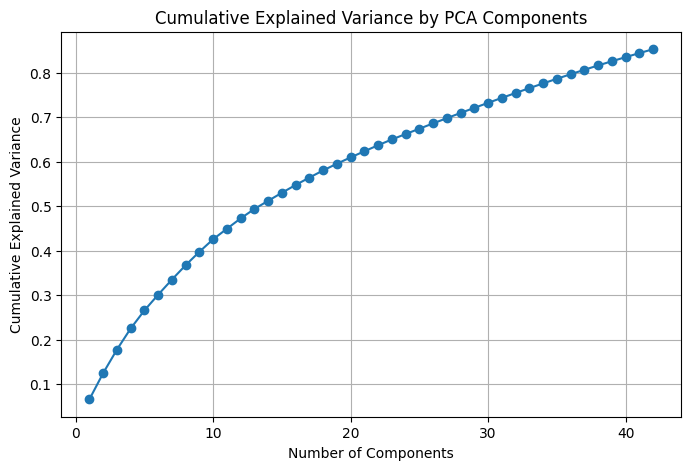

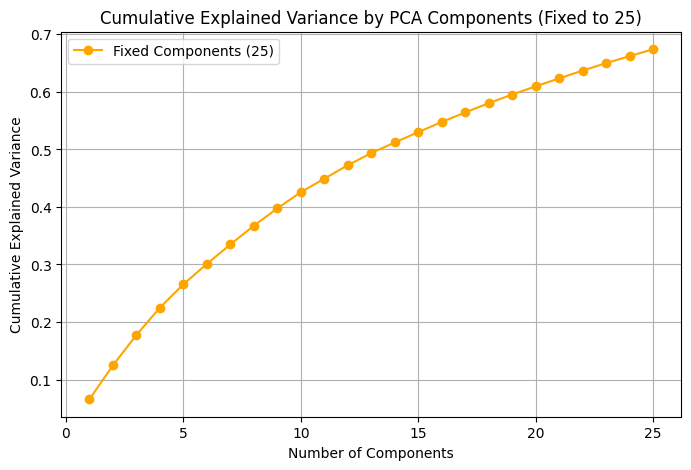

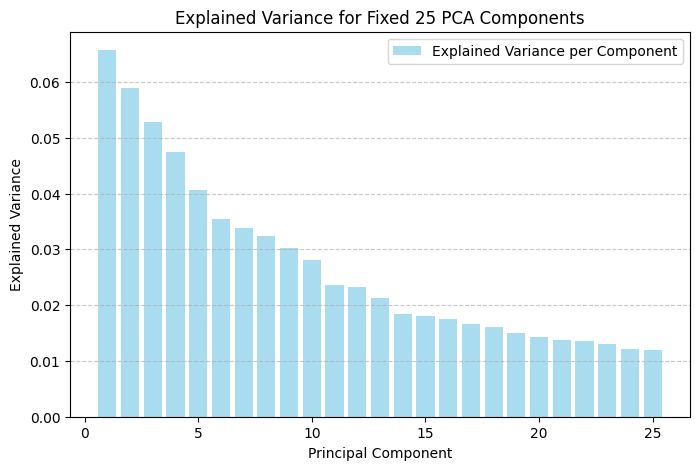

In [ ]:
# ===========================
# 4. Explained Variance Plot
# ===========================
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# ===========================
# 5. Explained Variance for Fixed Components
# ===========================
plt.figure(figsize=(8, 5))

# Plot the cumulative explained variance for fixed components (25)
plt.plot(range(1, 26), 
         pca_fixed.explained_variance_ratio_.cumsum(), marker='o', label='Fixed Components (25)', color='orange')

# Add title and labels
plt.title('Cumulative Explained Variance by PCA Components (Fixed to 25)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.legend()
plt.show()

# ===========================
# 6. Explained Variance for Individual Fixed Components
# ===========================
plt.figure(figsize=(8, 5))

# Plot individual explained variance of each fixed component
plt.bar(range(1, 26), 
        pca_fixed.explained_variance_ratio_, alpha=0.7, align='center', label='Explained Variance per Component', color='skyblue')

# Add title and labels
plt.title('Explained Variance for Fixed 25 PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [ ]:
# ===========================
# 7. Save Transformed Data
# ===========================
# Create a new DataFrame for PCA-transformed data
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the target variable back if needed
if 'risk_premium' in data.columns:
    X_pca_df['risk_premium'] = data['risk_premium']

# Save the PCA-transformed dataset
X_pca_df.to_csv("pca_transformed_sample_dataset.csv", index=False)
print("PCA-transformed dataset saved as 'pca_transformed_dataset.csv'.")

PCA-transformed dataset saved as 'pca_transformed_dataset.csv'.


In [34]:

import pandas as pd

# Load your dataset
data = pd.read_csv("pca_transformed_sample_dataset.csv")

# List of features to check
features_to_check = ['sic2', 'name', 'month', 'risk_premium', 'DATE']

# Check if each feature exists in the dataset
for feature in features_to_check:
    if feature in data.columns:
        print(f"Feature '{feature}' exists in the dataset.")
    else:
        print(f"Feature '{feature}' does NOT exist in the dataset.")


# # 2. Identify and Drop Columns with Missing Values
# # ===========================
# # Use only numeric columns (remove target variable and non-numeric features)
# X = data.select_dtypes(include=['int64', 'float64']).drop(columns=['risk_premium'])

# # Check for missing values and identify columns to drop
# missing_columns = X.columns[X.isna().sum() > 0].tolist()
# print("Columns with missing values:", missing_columns)

# # Drop columns with missing values
# X = X.drop(columns=missing_columns)
# Display the structure of the cleaned dataset
print("\nDataset after dropping columns with NaN values:")
print(data.info())

Feature 'sic2' exists in the dataset.
Feature 'name' exists in the dataset.
Feature 'month' exists in the dataset.
Feature 'risk_premium' exists in the dataset.
Feature 'DATE' exists in the dataset.

Dataset after dropping columns with NaN values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890593 entries, 0 to 890592
Data columns (total 47 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   PC1           890593 non-null  float64
 1   PC2           890593 non-null  float64
 2   PC3           890593 non-null  float64
 3   PC4           890593 non-null  float64
 4   PC5           890593 non-null  float64
 5   PC6           890593 non-null  float64
 6   PC7           890593 non-null  float64
 7   PC8           890593 non-null  float64
 8   PC9           890593 non-null  float64
 9   PC10          890593 non-null  float64
 10  PC11          890593 non-null  float64
 11  PC12          890593 non-null  float64
 12  PC13          890593

In [33]:
import pandas as pd

# ===========================
# 1. Load Datasets
# ===========================
# Load the original dataset (before PCA)
original_data = pd.read_csv("cleaned_sample_dataset.csv")

# Load the PCA-transformed dataset
pca_data = pd.read_csv("pca_transformed_sample_dataset.csv")

# ===========================
# 2. Add Back Important Features
# ===========================
# List of features to add back
features_to_add = ['sic2', 'name', 'month', 'DATE']

# Add features from the original dataset to the PCA dataset
for feature in features_to_add:
    if feature in original_data.columns:
        print(f"Adding feature '{feature}' back to the PCA-transformed dataset.")
        pca_data[feature] = original_data[feature]
    else:
        print(f"Feature '{feature}' does NOT exist in the original dataset and cannot be added.")

# ===========================
# 3. Save the Updated Dataset
# ===========================
# Save the dataset with added features
pca_data.to_csv("pca_transformed_sample_dataset.csv", index=False)
print("\nUpdated dataset saved as 'pca_transformed_with_original_features.csv'.")

Adding feature 'sic2' back to the PCA-transformed dataset.
Adding feature 'name' back to the PCA-transformed dataset.
Adding feature 'month' back to the PCA-transformed dataset.
Adding feature 'DATE' back to the PCA-transformed dataset.

Updated dataset saved as 'pca_transformed_with_original_features.csv'.
